# (Not) another Airbnb Seattle story: A detailed look on apartment prices

## Introduction
This project is the first project of the Udacity Data Scientist Nano Degree program. I am going to use the CRISP-DM process to write a data science blog post.

CRISP-DM (Cross Industry Process for Data Mining) is a process model with six phases that describes the data science life cycle. It consists of 6 phases:

- Business Understanding
- Data Understanding
- Data Preparation
- Modeling
- Evaluation
- Deploy

However, not all of the 6 phases aren't necessary for each the project. In the following I will mainly focus on parts 1,2,3 and 4. The dataset is available on Inside Airbnb, an independent, non-commercial website that allows you to explore how Airbnb is  used in cities around the world:: http://insideairbnb.com/get-the-data.html.

## 1. Business Understanding

As a task for this project at least three main business-related questions have to be answered. As can be asumed from the title, I will use the Airbnb Seattle dataset to answer the following questions:  

- "What are the most common property types offered in Seattle and how much do they cost?

- "How do the prices for apartments in Seattle develop during one year?

- "How do the prices for apartments in different quarters develop during one year?"

The main idea behind these questions is a planned trip to Seattle during summer. I have never been to Seattle but its scenic setting at the waterside and the close mountains which are well-known for hiking make it a really interesting holiday destination for me. So I started with some easy to follow data analysis to visualize price distributions of different housing types and how the prices develop during the year in different neighbourhoods. Besides the prices, also a proper choiche of the neighbourhood for the holiday stay can make a big difference. A cheap stay, close to the city center can make all the difference for an enjoyable holiday. 

# Import section

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Functions section

In [3]:
def update_price_column(df):
    """
    Description: This function can be used to clean the price column. It replaces "$" and ","
    and changed dtype to numeric.

    Arguments:
        df:   dataframe  

    Returns:
        df:   updated dataframe
    """
    
    df['price'] = df['price'].str.replace('$','').str.replace(',','')
    df['price'] = pd.to_numeric(df['price'])
    
    return df


def get_number_of_hosts_dict(df, list, min_number):
    """
    Description: Creates a dictionary that contains the number of individual hosts per property type.
        

    Arguments:
        df:         dataframe
        list:       list of different property types
        min_number: minimum number of occurences of the property type that it will be included to the dictionary

    Returns:
        dict:       a dictionary with the informations about the number of unique entries of a property type
    """

    
    dictionary = {}
    
    for type in list:
        
        dictionary[type] = df[df['property_type'] == type]['host_id'].nunique()
        
    dictionary = {k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1], reverse =True) if v > min_number}
    
    return(dictionary)


def extract_df(df, dict):
    """
    Description: Creates a dictionary that contains the number of individual hosts per property type.
        

    Arguments:
        df:         dataframe
        dict:       a dictionary with the informations about the number of unique entries of a property type.
                result of def get_number_of_hosts_dict()

    Returns:
        df_new:     dataframe consisting only of the entries in dict
    """
    
    count = 0
    
    for key, val in dict.items():
        
        if count == 0:
                
            df_new = df[df['property_type'] == key]
            count =+1
                
        else:
            df_new = df_new.append(df[df['property_type'] == key])
    
    return(df_new)

def weekend(x):
    """
    Description:  assigns the "weekend nights" (Friday and Saturday) to the weekday number of df. Can be used with apply and
                  a lambda function.
        

    Arguments:
        x:          int, entry in the column where this function is applied to.

    Returns:
        y:          str, depending on the value of x it is either "Fr", "Sa" or "else"
    """

    if x == 5:
        y = 'Sa'
    elif x == 4:
        y = 'Fr'
    else:
        y = 'else'
    
    return(y)


## Question 1: "What are the most common property types offered in Seattle and how much do they cost?"



### Gather, assess and clean data

The Seattle_listings dataset contains detailed information on all the available offers for Airbnb stays in Seatlle. There are 3818 entries in the table with 92 columns. It contains information about the host, the neighbourhood, the property (number of rooms, bathrooms, kichten, ...) and some review data.
In the following, I will focus on the different property types and investigate the price distribution of the five most common property types in Seattle. 


In [4]:
listings_df = pd.read_csv('Seattle_listings.csv')

''' convert price column to int '''

listings_df = update_price_column(listings_df)

''' get list of property types that exist'''

property_types_list = listings_df.property_type.dropna().unique()


''' get a dict of only the property types that have an occurence > 25 '''

hosts_numbers_dict = get_number_of_hosts_dict(listings_df, property_types_list, 25)

''' get a new df with the property types in hosts_numbers_dict '''

extracted_df = extract_df(listings_df, hosts_numbers_dict)
print(extracted_df.groupby('property_type')['price'].mean())

property_type
Apartment      122.932670
Condominium    151.109890
House          132.351414
Loft           135.700000
Townhouse      129.457627
Name: price, dtype: float64


### Visualize data

Text(0.5, 1.0, 'AirBnB price distribution of common property types in Seattle')

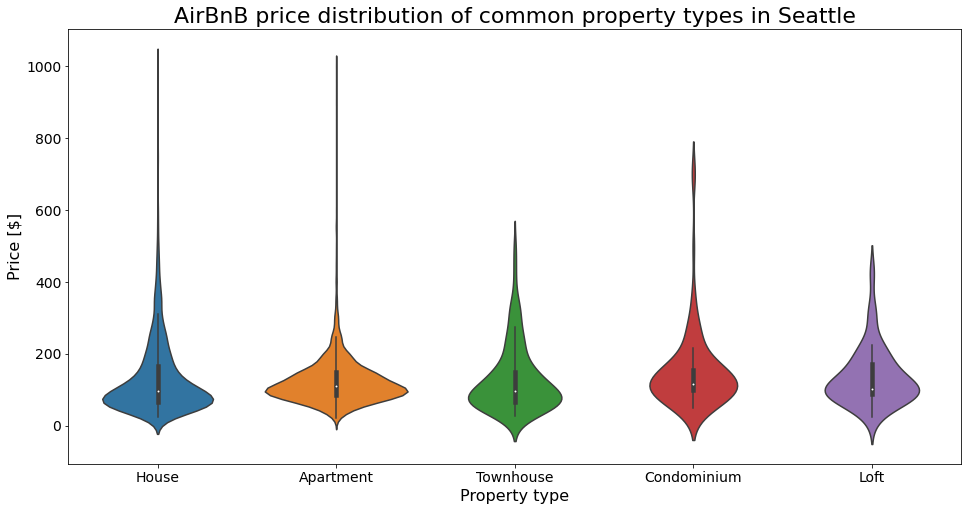

In [4]:
plt.figure(figsize=(16, 8))

sns.violinplot(x='property_type', y = 'price', data = extracted_df)

plt.xlabel('Property type', fontsize = 16)
plt.xticks(fontsize = 14)
plt.ylabel('Price [$]', fontsize = 16)
plt.yticks(fontsize = 14)
plt.title('AirBnB price distribution of common property types in Seattle', fontsize = 22)

## Evaluate Data
In total there are 16 different property types offered in Seattle. The 5 most common can be found here. By far the most common offerings are "houses" (1312) and "apartments" (1263), whereas "townhouses" (100), "condominium" (72) and "loft" (39) are well below. From the violin plots, the price distributions of the different housing types are clearly visible. The mean prices (the white little dot) in the violins are in the range of 123 (apartments) to 151 (condominium) dollars. For houses and apartmens the price range spans upto 1000 dollars. The median values range from 95 (houses) to 115 (condonimium) dollars.
Due to the huge number of apartment offerings and this usually being my prefered housing stile, a more detailed look on the anual price development of apartment offerings will be given.

## Question 2: "How do the prices for apartments in Seattle develop during one year?"

To access this question, the Seattle_calender database needs to be loaded and transformed. It contains the information of the daily price development for every offer in Seattle. It only contains the four columns 'listing_id', 'date', 'available', 'price'. Since, I want to extract the anual price informations of all apartments that are listed in Seattle, I need to get a list of all 'listing_id' that are categorized as an apartment from the previous dataframe (extracted_df). To make sure, that a full year of data is used the last date will be 2017-01-03 since the entries started on 2016-01-04. In addition, the date is converted to a new column (weekday) which gives a number 0-6 to each day relating to Mo-Su. In a further column, these numbers will be used to discriminate between Fr and Saturday offerings and offerings on other days. In general offerings on Fr and Saturday are more expensive then offerings on other days of the week and I want to test this also here. 

### Gather, assess and clean data

In [23]:
s_cal = pd.read_csv('Seattle_calendar.csv')
print(s_cal.columns)
apartments_ids_list = extracted_df[extracted_df['property_type'] == 'Apartment']['id'].unique()

count = 0

for id in apartments_ids_list:
    if count == 0:
        apartments_cal_df = s_cal[s_cal['listing_id'] == id]
        count =+1
    else:
        apartments_cal_df = apartments_cal_df.append(s_cal[s_cal['listing_id'] == id]) 
        
"prepare aparmtments_cal_df"
apartments_cal_df['date'] = pd.to_datetime(apartments_cal_df['date'])
apartments_cal_df = apartments_cal_df[apartments_cal_df['date'] < '2017-01-04 00:00:00']
apartments_cal_df = update_price_column(apartments_cal_df)
apartments_cal_df = apartments_cal_df.drop('available', axis =1)
apartments_cal_df = apartments_cal_df.dropna()
"add columns for weekday and weekend and group price by date"
apartments_cal_df['weekday'] = apartments_cal_df['date'].dt.dayofweek 
apartments_cal_df['weekend'] = apartments_cal_df['weekday'].apply(lambda x: weekend(x))
apartments_cal_df = apartments_cal_df.join(apartments_cal_df.groupby('date')['price'].mean(), on='date', rsuffix='_mean')

Index(['listing_id', 'date', 'available', 'price'], dtype='object')


### Visualize data

Text(0.5, 1.0, 'Yearly development of apartment prices in Seattle')

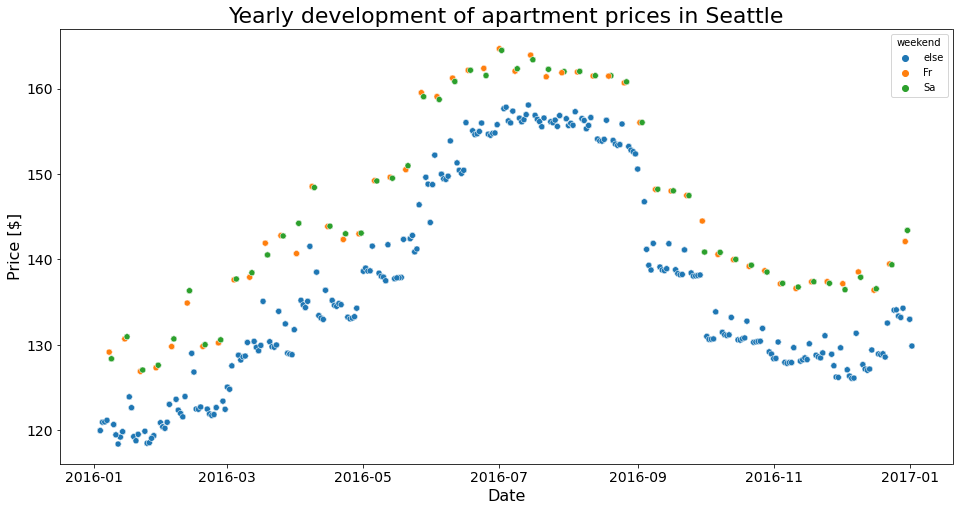

In [6]:
fig, ax = plt.subplots(figsize= (16,8))
sns.scatterplot(x='date', y='price_mean', hue = 'weekend', data=apartments_cal_df)

plt.xlabel('Date', fontsize = 16)
plt.xticks(fontsize = 14)
plt.ylabel('Price [$]', fontsize = 16)
plt.yticks(fontsize = 14)
plt.title('Yearly development of apartment prices in Seattle', fontsize = 22)

## Evaluate Data
The anual price development for apartments shows a clear peak during sommer months and a small increase around christmas time. In addition, stays on a Friday (orange) or Saturday (green) are in general more expensive than stays on other days of the week. From the general understanding, it can be assumed that this behavior also applys to other years. To avoid high prices during peak holiday season, it might therefore be a good advice to stay in Seattle in (early) September, as the weather might still be relatively nice but the prices are about 10 % lower. A detailed look on weather data for the last years might help on this question.  

## Question 3: "How do the prices for apartments in different quarters develop during one year?"

After having found this seasonal behaviour of aparmtment prices in Seattle, the question arises if this equally applies to all apartments in different neihbourhoods in Seattle. Maybe there is a way to stay close to the city center without having to pay that extra "summer" fee. 

### Gather, assess and clean data

In [25]:
neighbourhoods_df = listings_df[['id', 'neighbourhood_group_cleansed']]

'Get the central neighbourhoods'
neighbourhoods_central_df = neighbourhoods_df[(neighbourhoods_df['neighbourhood_group_cleansed'] == 'Capitol Hill') | (neighbourhoods_df['neighbourhood_group_cleansed'] == 'Downtown') | (neighbourhoods_df['neighbourhood_group_cleansed'] == 'Central Area') | (neighbourhoods_df['neighbourhood_group_cleansed'] == 'Queen Anne')]

apartments_central_df = apartments_cal_df.merge(neighbourhoods_central_df, left_on='listing_id', right_on='id').drop(['id', 'price_mean','weekend', 'weekday'] ,axis = 1)

print(apartments_central_df.groupby('neighbourhood_group_cleansed').nunique())

                              listing_id  date  price
neighbourhood_group_cleansed                         
Capitol Hill                         342   365    254
Central Area                         100   365    128
Downtown                             456   365    462
Queen Anne                           167   365    237


### Visualize data

Text(0.5, 1.0, 'Yearly development of apartment prices in different quarters of Seattle')

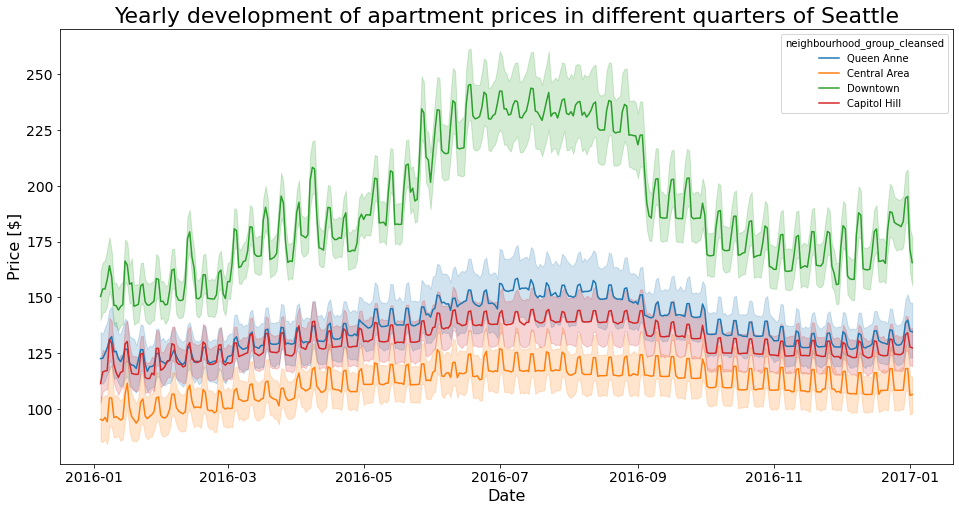

In [8]:
fig, ax = plt.subplots(figsize= (16,8))
sns.lineplot(x='date', y='price', hue = 'neighbourhood_group_cleansed', data=apartments_central_df)

plt.xlabel('Date', fontsize = 16)
plt.xticks(fontsize = 14)
plt.ylabel('Price [$]', fontsize = 16)
plt.yticks(fontsize = 14)
plt.title('Yearly development of apartment prices in different quarters of Seattle', fontsize = 22)

## Evaluate Data
This graph nicely shows, that the large peak in the annual apartment prices mainly arrises from apartments that are located in Downtown Seattle. The prices in the other neighbourhoods do not show such a pronounced seasonal trend. also the weekday/weekend change does not seem to be so distinct. 
The number of all apartment listings decrease from 456 (Downtown), 342 (Capitol Hill), 167 (Queen Anne) to 100 (Central Area). If the number of listings might be indicative of the "atractivity" of the neighbourhood, staying in Capitol Hill (so the "second" most attractive) might safe you upto 100 dollars a night during sommer. Of course a more in depth analysis of the data (e.g. looking at the neihbourhood reviews) might give further information on the difference of the neighbourhoods. But also an "oldschool" guidebook might do the trick